In [1]:
# ============================================
# Monod
# ============================================

In [2]:
# ===============================
# 1) Imports & Global Setup
# ===============================
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import deque
from itertools import product

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# Grid
NX, NY = 64, 148
L = NX * NY

# Paths
MODEL_PATH  = "../parameters/Monod.pt"                            # pretrained weights (Monod)
DOMAIN_PATH = "../geometries/Domain_Monod.npz"                    # raw domain, flat (9472,)
assert os.path.exists(MODEL_PATH),  f"Not found: {MODEL_PATH}"
assert os.path.exists(DOMAIN_PATH), f"Not found: {DOMAIN_PATH}"

# Physics conditions (4 combos = 2×2)
PE_VALUES  = (1.0, 10.0)
DA_VALUES  = (0.05, 0.5)

# Time steps (normalize by 80 → t_norm)
t_selected = np.array([1] + [i for i in range(4, 81, 4)], dtype=float)  # [1,4,8,...,80]
T_NORMS    = (t_selected / 80.0).tolist()

# Normalization ranges used in training for branch2 (Pe, Da)
PE_MIN, PE_MAX = 1.0, 10.0
DA_MIN, DA_MAX = 0.05, 0.5

def normalize_params_monod(pe, da):
    """Map raw (Pe, Da) to [0,1] based on training min/max."""
    pe_n = (float(pe) - PE_MIN) / (PE_MAX - PE_MIN)
    da_n = (float(da) - DA_MIN) / (DA_MAX - DA_MIN)
    return pe_n, da_n

DEVICE: cpu


In [3]:
# ===============================
# 2) GDF from domain (inlet-high, solid=0)
# ===============================
def boundary_distance_map(m_bin, boundary='inlet'):
    """
    4-neighbor geodesic distance through pores (1), starting from inlet(y=0) or outlet(y=ny-1).
    Seeds have distance 0.5; each pore step adds 1.0. Solids (0) are never visited.
    """
    nx, ny = m_bin.shape
    dist_map = np.zeros_like(m_bin, dtype=np.float32)

    if boundary == 'inlet':
        starts = [(i, 0) for i in range(nx) if m_bin[i, 0] == 1]
    else:
        starts = [(i, ny - 1) for i in range(nx) if m_bin[i, ny - 1] == 1]

    q = deque()
    for (x, y) in starts:
        dist_map[x, y] = 0.5
        q.append((x, y))

    # BFS on pores
    for_x = [-1, 1, 0, 0]
    for_y = [0, 0, -1, 1]
    while q:
        x, y = q.popleft()
        for dx, dy in zip(for_x, for_y):
            xx, yy = x + dx, y + dy
            if 0 <= xx < nx and 0 <= yy < ny and m_bin[xx, yy] == 1:
                new_dist = dist_map[x, y] + 1.0
                if dist_map[xx, yy] == 0 or dist_map[xx, yy] > new_dist:
                    dist_map[xx, yy] = new_dist
                    q.append((xx, yy))
    return dist_map

def make_inlet_distance_norm(m_bin):
    """
    Match training-time normalization:
      - compute inlet distance via BFS
      - set solids to max+1, negate
      - normalize using vmin/vmax over the FULL grid (finite mask)
      - finally set solids to 0
    """
    dist_inlet = boundary_distance_map(m_bin, boundary='inlet')
    if (m_bin == 1).any():
        max_val = float(np.nanmax(dist_inlet[m_bin == 1]))
    else:
        max_val = 0.0
    dist_inlet[m_bin == 0] = max_val + 1.0
    dist_inlet = -dist_inlet

    valid = np.isfinite(dist_inlet)
    vmin = float(dist_inlet[valid].min())
    vmax = float(dist_inlet[valid].max())

    gdf = np.zeros_like(dist_inlet, dtype=np.float32)
    if vmax > vmin:
        gdf[valid] = (dist_inlet[valid] - vmin) / (vmax - vmin)
    else:
        gdf[valid] = 0.0

    gdf[m_bin == 0] = 0.0
    return gdf

# Load domain & build binary mask
arr = np.load(DOMAIN_PATH)
m_flat = arr["m"] if "m" in arr.files else arr[list(arr.files)[0]]
m_hw   = m_flat.reshape(NX, NY)
m_bin  = (m_hw > 0.5).astype(np.int32)  # 1=pore, 0=solid

# Compute GDF
GDF = make_inlet_distance_norm(m_bin)

In [5]:
# ===============================
# 3) Build inputs for the 4 conditions at a given time t_norm
# ===============================

COND_PAIRS = [(pe, da) for pe, da in product(PE_VALUES, DA_VALUES)]
N_COND = len(COND_PAIRS)  # 4

# Static parts: geometry & coords & aux
B1_np = np.repeat(m_bin[None, None, ...], N_COND, axis=0).astype(np.float32)  # (N,1,H,W)

x_coords = np.arange(NX, dtype=np.float32) / (NX - 1)
y_coords = np.arange(NY, dtype=np.float32) / (NY - 1)
X, Y = np.meshgrid(x_coords, y_coords, indexing="ij")  # (NX,NY)
aux = GDF.astype(np.float32)                            # (NX,NY)

# stack for convenience: [x, y, aux]
xy_aux_flat = np.stack([X.reshape(-1), Y.reshape(-1), aux.reshape(-1)], axis=1)  # (L,3)

def build_inputs_for_time(t_norm: float):
    """
    Returns torch tensors shaped for the Monod model at a single time:
      - branch1: (N,1,H,W)
      - branch2: (N,2) normalized (Pe, Da)
      - trunk  : (N,1,L,4) with columns (x,y,t_norm,aux)
    """
    # branch2 normalized
    B2_np = np.array([normalize_params_monod(pe, da) for (pe, da) in COND_PAIRS],
                     dtype=np.float32)  # (N,2)

    # trunk with constant t per condition
    t_col = np.full((L, 1), float(t_norm), dtype=np.float32)

    # 학습과 동일한 순서: (x, y, t, aux)
    trunk_single = np.concatenate(
        [xy_aux_flat[:, :2], t_col, xy_aux_flat[:, 2:3]],
        axis=1
    )  # (L,4)

    T_np = np.repeat(trunk_single[None, None, ...], N_COND, axis=0).astype(np.float32)  # (N,1,L,4)

    # to torch
    B1_t = torch.tensor(B1_np, dtype=torch.float32)
    B2_t = torch.tensor(B2_np, dtype=torch.float32)
    T_t  = torch.tensor(T_np,  dtype=torch.float32)
    return B1_t, B2_t, T_t

T_NORMS_SHOW = [0.2, 0.4, 0.6, 0.8, 1.0]

# Sanity check for one time
_b1, _b2, _t = build_inputs_for_time(T_NORMS_SHOW[0])
print("shapes: branch1", tuple(_b1.shape), ", branch2", tuple(_b2.shape), ", trunk", tuple(_t.shape))

shapes: branch1 (4, 1, 64, 148) , branch2 (4, 2) , trunk (4, 1, 9472, 4)


In [6]:
# ===============================
# 4) Model Definition & Load Weights
# ===============================

class BranchCNN(nn.Module):
    def __init__(self, in_channels, out_dim, num_blocks=5):
        super().__init__()
        channels = [in_channels, 16, 32, 64, 128, 256][:num_blocks+1]
        layers = []
        for i in range(num_blocks):
            layers += [
                nn.Conv2d(channels[i], channels[i+1], 3, 1, 1),
                nn.SiLU(),
                nn.AvgPool2d(2)
            ]
        self.features = nn.Sequential(*layers)
        h, w = 64, 148
        for _ in range(num_blocks):
            h //= 2
            w //= 2
        self.fc = nn.Linear(channels[num_blocks]*h*w, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class BranchFNN(nn.Module):
    def __init__(self, in_dim=2, out_dim=128, hidden_dim=128, num_layers=3):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.SiLU()]
        for _ in range(num_layers-2):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.SiLU()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def create_trunk_net(trunk_in_dim, out_dim, num_layers=8, width=128):
    layers = [nn.Linear(trunk_in_dim, width), nn.SiLU()]
    for _ in range(num_layers-2):
        layers += [nn.Linear(width, width), nn.SiLU()]
    layers += [nn.Linear(width, out_dim)]
    return nn.Sequential(*layers)

class PRT_DeepONet_Monod(nn.Module):
    def __init__(self, nx=64, ny=148, trunk_in_dim=4, out_dim=128, branch2_in_dim=2, cnn_blocks=5):
        super().__init__()
        self.branch1_net = BranchCNN(1, out_dim, num_blocks=cnn_blocks)
        self.branch2_net = BranchFNN(branch2_in_dim, out_dim)
        self.trunk_net   = create_trunk_net(trunk_in_dim, out_dim)
        self.bias = nn.Parameter(torch.zeros(1))
        self.nx = nx
        self.ny = ny
    def forward(self, branch1_input, branch2_input, trunk_input):
        # 허용 형태: (N, L, 4) 또는 (N, 1, L, 4)
        if trunk_input.ndim == 4:
            trunk_input = trunk_input.squeeze(1)   # (N,L,4)
        N, L, D = trunk_input.shape
        trunk_out   = self.trunk_net(trunk_input)          # (N,L,C)
        trunk_out   = trunk_out.unsqueeze(1)               # (N,1,L,C)
        branch1_out = self.branch1_net(branch1_input).unsqueeze(1).unsqueeze(2)  # (N,1,1,C)
        branch2_out = self.branch2_net(branch2_input).unsqueeze(1).unsqueeze(2)  # (N,1,1,C)
        out = (branch1_out * branch2_out * trunk_out).sum(-1) + self.bias        # (N,1,L)
        out = out.view(N, self.nx, self.ny, 1)                                    # (N,H,W,1)
        return out

# Instantiate & load weights
model = PRT_DeepONet_Monod(
    nx=NX, ny=NY,
    trunk_in_dim=4,     # (x, y, t, GDF)
    out_dim=128,
    branch2_in_dim=2,   # (Pe, Da)
    cnn_blocks=5
).to(DEVICE)

# Robust load
try:
    state = torch.load(MODEL_PATH, map_location=DEVICE)
    state_dict = state.get("state_dict", state) if isinstance(state, dict) else state
except Exception:
    state = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
    state_dict = state.get("state_dict", state) if isinstance(state, dict) else state

missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded weights:", MODEL_PATH)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
model.eval()

Loaded weights: ./Monod.pt
Missing keys: []
Unexpected keys: []


PRT_DeepONet_Monod(
  (branch1_net): BranchCNN(
    (features): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): SiLU()
      (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): SiLU()
      (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): SiLU()
      (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): SiLU()
      (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): SiLU()
      (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (fc): Linear(in_features=2048, out_features=128, bias=True)
  )
  (branch2_net): BranchFNN(
    (net): Sequential(
      (0): Linear(in_features=2,

Pred sequence: (5, 4, 64, 148)


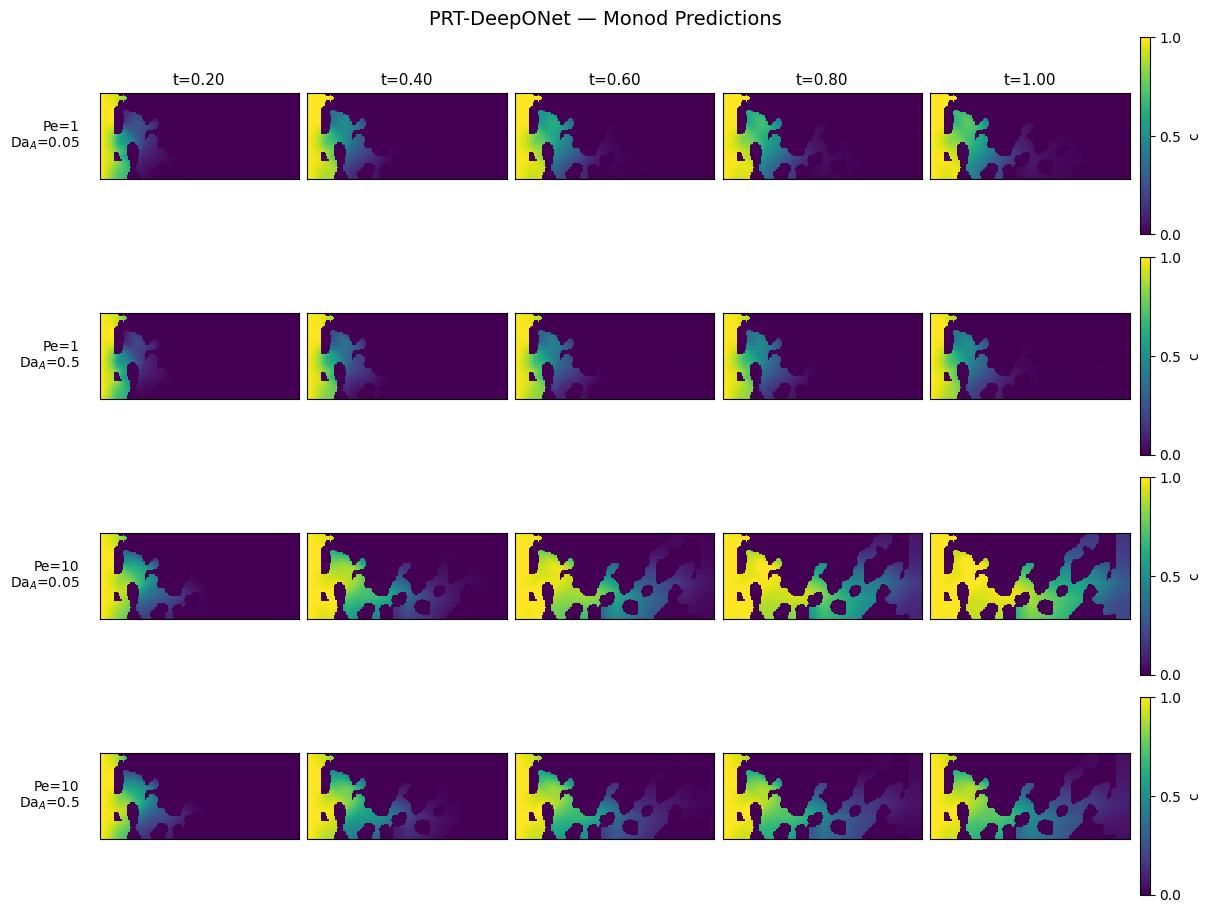

In [9]:
# ===============================
# 5) Predict for the 4 conditions across chosen time steps
# ===============================
@torch.no_grad()
def predict_batch(model, B1, B2, T, device=DEVICE):
    y = model(B1.to(device), B2.to(device), T.to(device)).cpu()  # (N,H,W,1)
    return y[..., 0].contiguous()  # (N,H,W)

Y_seq = []  # (Ts, N, H, W)
mask_torch = torch.from_numpy(m_bin.astype(bool)).unsqueeze(0)  # (1,H,W)

for t_norm in T_NORMS_SHOW:
    B1_t, B2_t, T_t = build_inputs_for_time(t_norm)
    y_t = predict_batch(model, B1_t, B2_t, T_t, device=DEVICE)   # (N,64,148)
    y_t = torch.clamp(y_t, 0.0, 1.0)                             # (optional) clip
    y_t = torch.where(mask_torch, y_t, torch.zeros_like(y_t))    # solids = 0 (display-consistent)
    Y_seq.append(y_t)

Y_seq = torch.stack(Y_seq, dim=0)   # (Ts, N, H, W) == (len(T_NORMS_SHOW), 4, 64, 148)
print("Pred sequence:", tuple(Y_seq.shape))

# ====== 6) Visualization — 4 rows (conditions) × len(T_NORMS_SHOW) cols ======
rows, cols = len(COND_PAIRS), len(T_NORMS_SHOW)
fig, axes = plt.subplots(rows, cols, figsize=(2.4*cols, 2.2*rows), constrained_layout=True)

col_titles = [f"t={t:.2f}" for t in T_NORMS_SHOW]

for i, (pe, da) in enumerate(COND_PAIRS):
    row_im = None
    for j, t_norm in enumerate(T_NORMS_SHOW):
        ax = axes[i, j] if rows > 1 else axes[j]
        im = ax.imshow(
            Y_seq[j, i].numpy(),
            origin="lower",
            interpolation="nearest")
        if row_im is None:
            row_im = im
        if i == 0:
            ax.set_title(col_titles[j], fontsize=11)
        ax.set_xticks([]); ax.set_yticks([])

    left_label = f"Pe={pe:g}\nDa$_A$={da:g}"
    axes[i, 0].text(
        -0.10, 0.5, left_label,
        transform=axes[i, 0].transAxes,
        ha="right", va="center",
        fontsize=10,
        linespacing=1.1,
        clip_on=False
    )
    cbar = fig.colorbar(
        row_im, ax=axes[i, :],
        orientation="vertical",
        fraction=0.03, pad=0.01
    )
    cbar.set_label("c", fontsize=10)
    cbar.set_ticks([0.0, 0.5, 1.0])

plt.suptitle("PRT-DeepONet — Monod Predictions", y=1.02, fontsize=14)
plt.show()